# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re

import umap.umap_ as umap


from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

from plotly import express as px

from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load dataset

In [3]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

In [4]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
255927,559401,20677,PINK POLKADOT BOWL,1,6-Jul-17,1.25,15039.0,United Kingdom
252545,559126,46000S,POLYESTER FILLER PAD 40x40cm,10,4-Jul-17,1.45,17341.0,United Kingdom
265194,560209,22893,MINI CAKE STAND T-LIGHT HOLDER,4,13-Jul-17,0.42,15004.0,United Kingdom
266845,560271,21985,PACK OF 12 HEARTS DESIGN TISSUES,1,15-Jul-17,0.29,16474.0,United Kingdom
63127,541522,22193,RED DINER WALL CLOCK,2,17-Jan-17,8.50,17419.0,United Kingdom
497287,578358,22804,PINK HANGING HEART T-LIGHT HOLDER,160,22-Nov-17,2.55,15482.0,United Kingdom
408265,571931,21929,JUMBO BAG PINK VINTAGE PAISLEY,6,17-Oct-17,4.13,NaN,United Kingdom
385901,570219,23308,SET OF 60 VINTAGE LEAF CAKE CASES,4,7-Oct-17,0.55,16809.0,United Kingdom
510022,579413,22866,HAND WARMER SCOTTY DOG DESIGN,4,27-Nov-17,2.10,13668.0,United Kingdom
86457,543546,84849B,FAIRY SOAP SOAP HOLDER,1,7-Feb-17,3.29,NaN,United Kingdom


# Descrição dos dados

In [5]:
df1 = df_raw.copy()

## Rename Columns

In [6]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [7]:
df1.shape

(541909, 8)

## Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format( 1 - (df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25%


## Change dtypes

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [12]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributs

In [15]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

#### Numerical Attributs - Investigating

1. quantidade negativa (pode ser devolução)
2. preço unitário igual a zero (pode ser promoção?)


### Categorical Attributs

#### Invoice No

In [16]:
#problema: temos letras no meio dos números

df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]', x))), :]

print('Total number of invoices: {}'.format( len (df_letter_invoice)))
print('Total de número negativos no quantity: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Total number of invoices: 8905
Total de número negativos no quantity: 8905


#### Stock Code

In [17]:
#check stock codes only caracters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### Description

In [18]:
#delete description

#### Country

In [19]:
df1['country'].value_counts( normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [20]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# Filtragem de variáveis

In [21]:
df2 = df1.copy()

In [22]:
#===== Numerical Attribuets =====
#unit price > 0
#eliminando os brindes e erros de base
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code != [POST, D, M, DOT,CRUK]
#removendo os stock codes errados
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'DOT', 'CRUK'])]

#description
df2 = df2.drop( columns='description', axis=1)

#country
#como usaremos lat e long de cada país, sera necessario remover união europeia e não especificado
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# Feature Engineering

In [23]:
df3 = df2.copy()

## Feature Creation

In [24]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country' ], axis=1).drop_duplicates(ignore_index=True)

In [25]:
#Gross Revenue (Faturamento)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [26]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [27]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [28]:
#Frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [29]:
#avg ticket (ticket médio)
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [30]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


# EDA (Explory Data Analysis)

In [31]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# Data Preparation

In [32]:
df5 = df4.copy()

In [33]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])

In [34]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


# Feature Selection

In [35]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [36]:
X = df6.drop(columns=['customer_id'])

In [37]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377193,2.791512,3.889210,-0.033939
1,0.135388,-0.361004,0.620928,-0.033427
2,0.524404,-0.899726,1.405316,-0.026622
3,-0.120499,0.028072,0.098003,-0.023244
4,-0.128592,2.402435,-0.163459,0.152443


##  Within-Cluster Sum of Square (Wss)

In [38]:
clusters = [2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'WSS vs K')

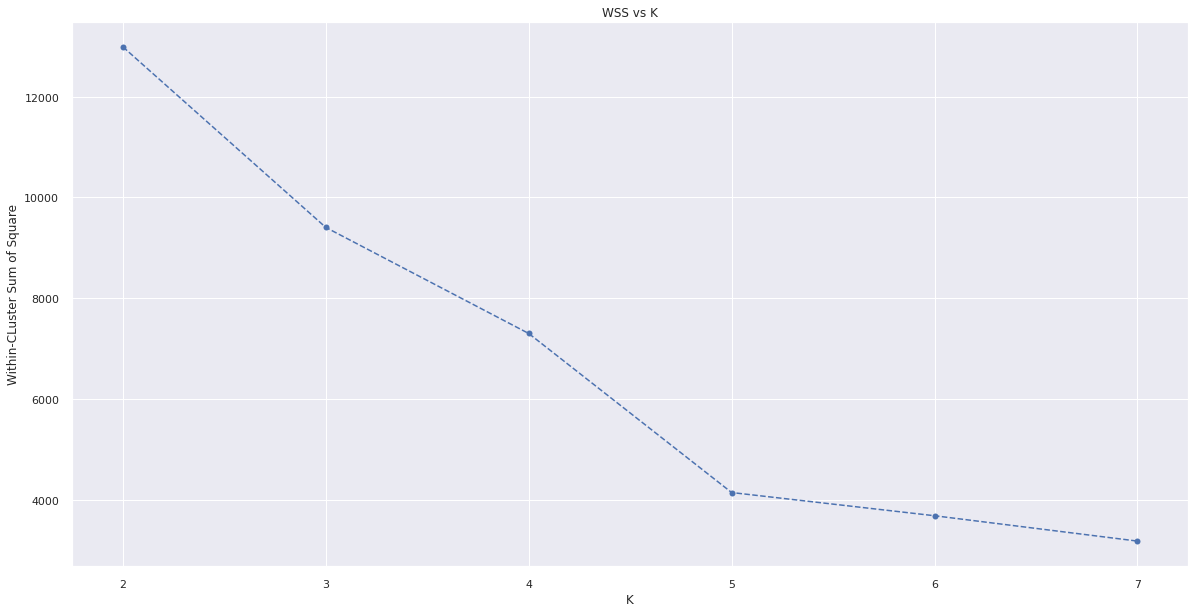

In [39]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

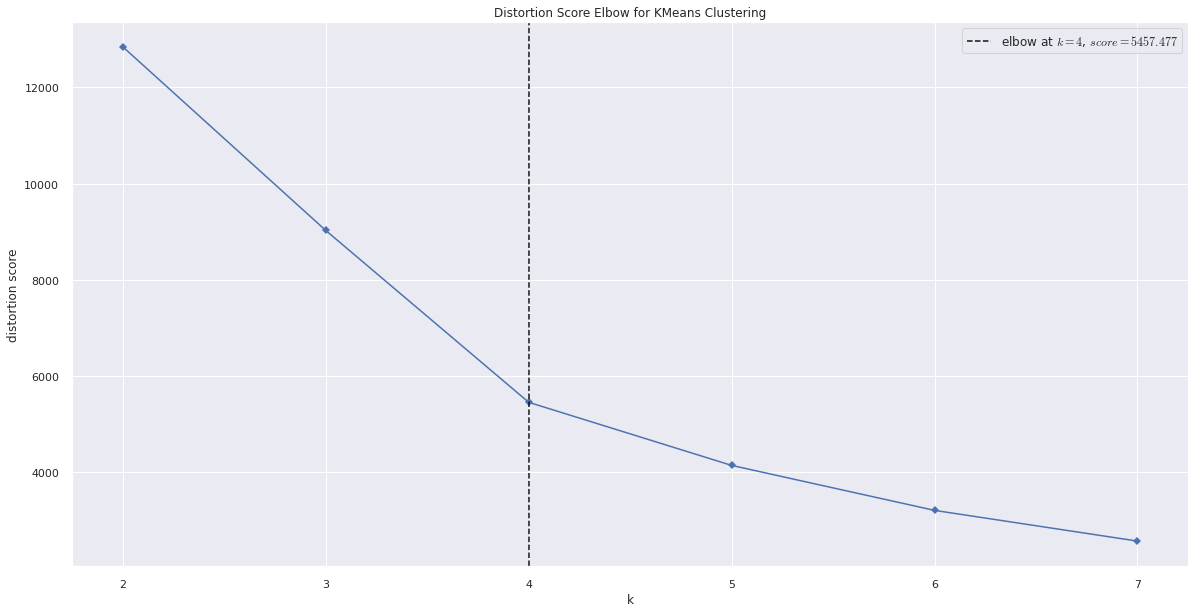

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show()

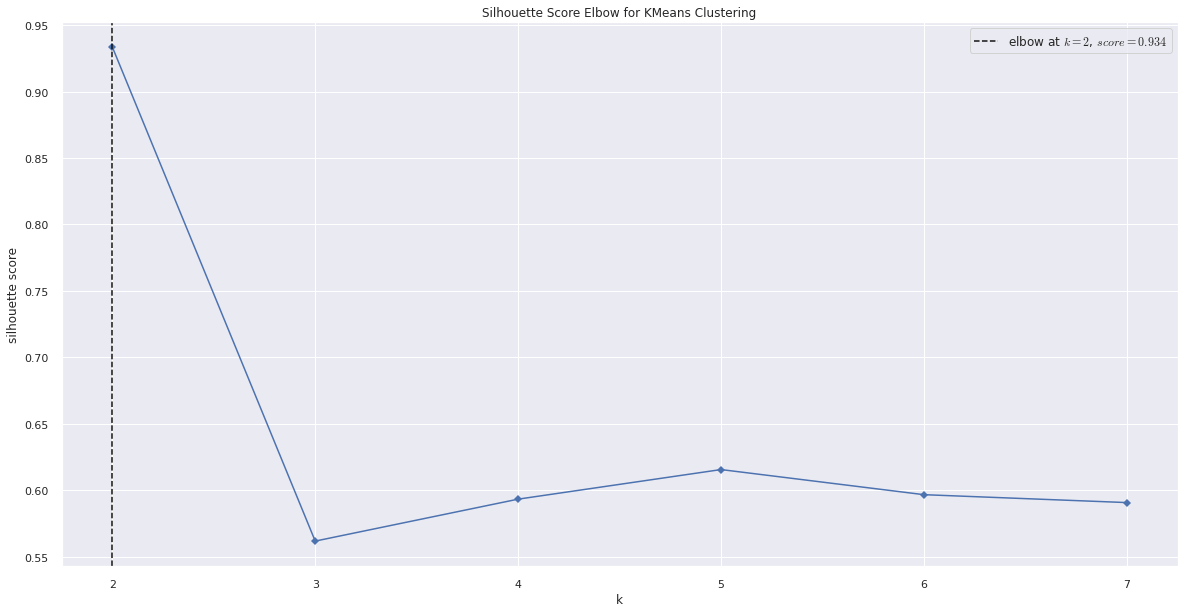

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [41]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show()

## Sillhouette Analysis

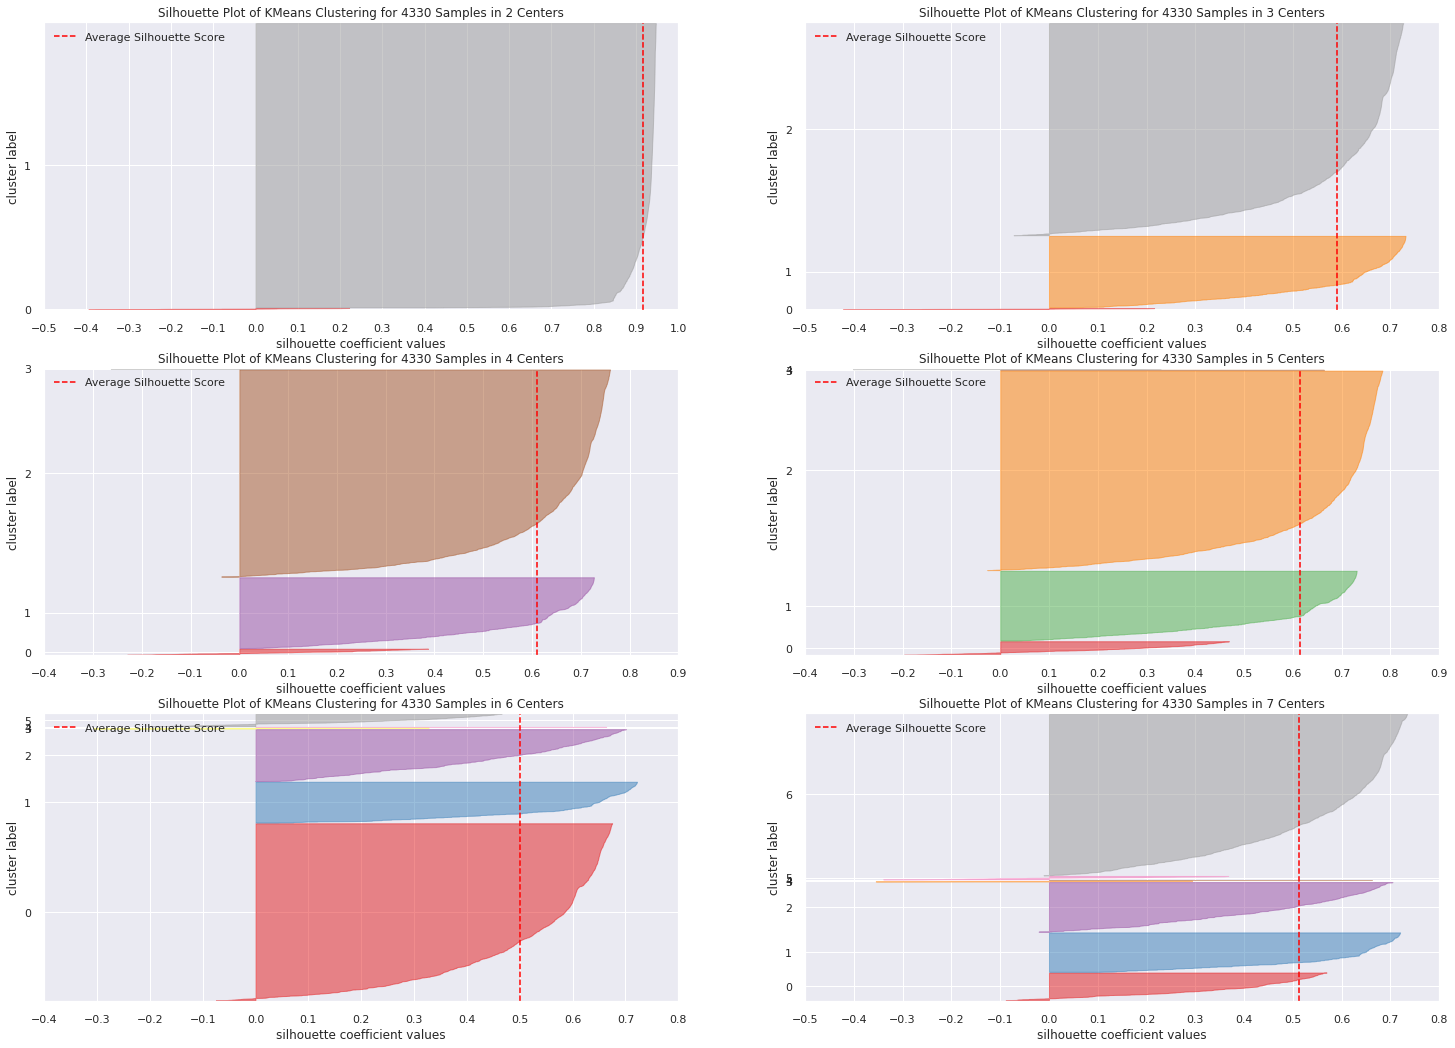

In [42]:
k=2

fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# Model Training

## K-Means

In [43]:
#model definition
k = 4
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## Cluster Validation

In [44]:
from sklearn import metrics as m
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 7301.655181329693
SS value: 0.6106827334420636


# Cluster Analysis

In [45]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


In [46]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,clusters
0,17850,0.377193,2.791512,3.889210,-0.033939,0
1,13047,0.135388,-0.361004,0.620928,-0.033427,2
2,12583,0.524404,-0.899726,1.405316,-0.026622,2
3,13748,-0.120499,0.028072,0.098003,-0.023244,2
4,15100,-0.128592,2.402435,-0.163459,0.152443,1


## Vizualization Inspection

/home/alex/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


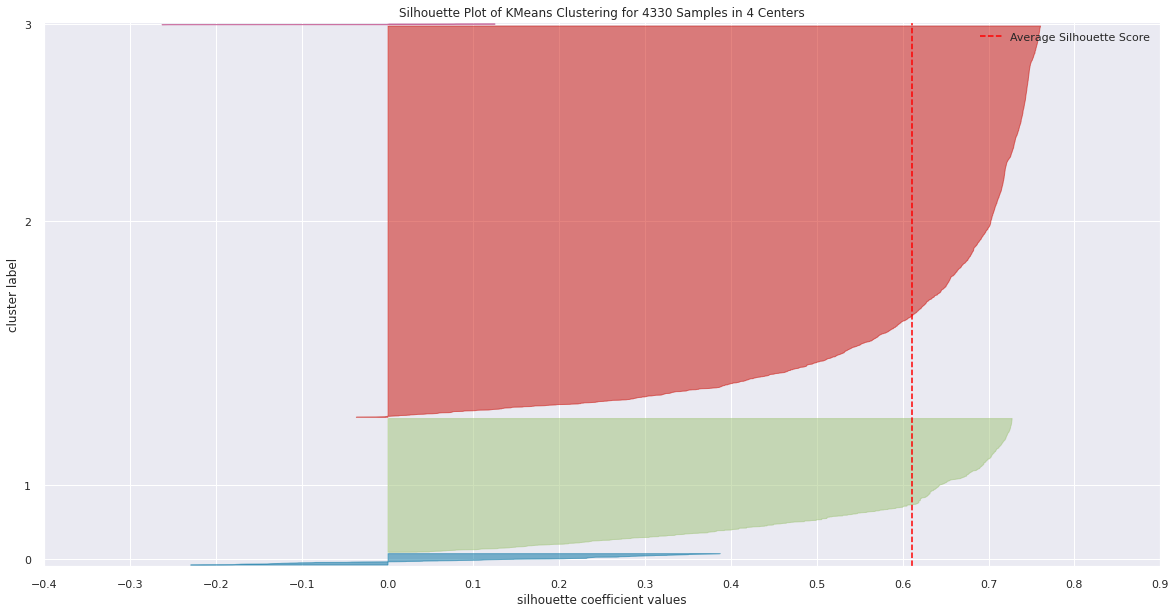

In [47]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

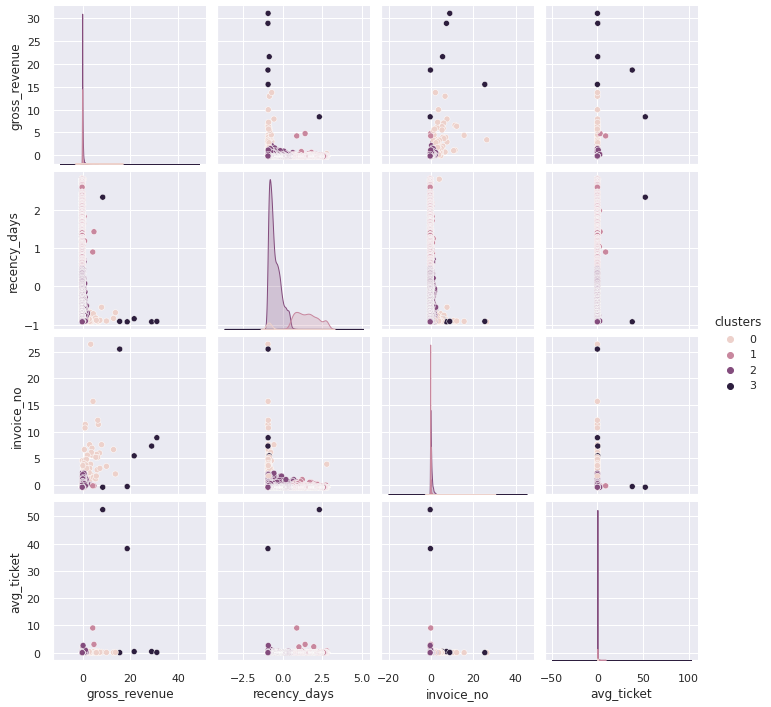

In [48]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

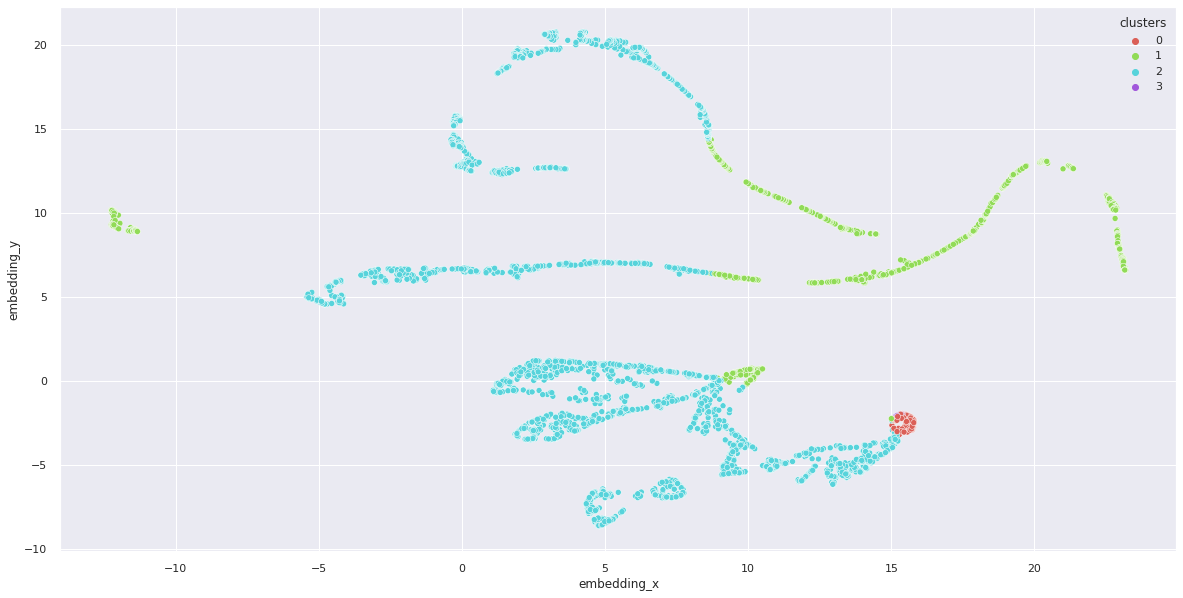

In [49]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [50]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
df_avg_invoice_no = df9[['invoice_no', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [51]:
df_cluster.head()
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,93,2.147806,2.389503,-0.823240,4.098662,0.012263
1,1,1078,24.896074,-0.164971,1.544768,-0.353978,-0.008516
2,2,3153,72.817552,-0.053417,-0.503179,-0.014568,-0.026434
3,3,6,0.138568,20.672886,-0.362667,7.723995,15.231134


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares